In [1]:
import cv2
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# Part 1: A cellular automata model

    
In the first part of this tutorial, we'll apply the concept of cellular automata (CA) to the modeling of the spread of the COVID-19 disease. Cellular au-tomata are algorithms that describe the discrete spatial and temporal evolution of complex systems by applying local deterministic orprobabilistic transformation rules to the cells of a regular lattice. 

## Simple SEIR-CA model

In this part, the spread of COVID-19 is modeled in a geographically distributed population. This disease is assumed to be a derivation of the susceptible-exposed-infectious-recovered (SEIR) model. People are first covertly infected and they will only show symptoms after an incubation period. For simplicity, it is assumed that no persons will die during the simulation (related or unrelated to the illness). And a recovered person will never suffer from the illness again.  
The simulation function of SEIR can be written as 

$$\frac{d S}{d t} =-\beta \frac{S I}{N}$$

$$\frac{d E}{d t} =\beta \frac{S I}{N}-\sigma E$$

$$\frac{d I}{d t} =\sigma E-\gamma I$$

$$\frac{d R}{d t} =\gamma I$$
$$N = S+E+I+R$$
where $S, E, I, R$ stands for the *Susceptible*, *Exposed*, *Infected*, *Recovered* people respectively. 

- $N$ is the total number of population, 
- $\beta$ controls how often a susceptible-infected contact results in a new exposure, 
- $\gamma$ is	the rate an infected recovers and moves into the resistant phase, 
- $\sigma$ is the rate an exposed person becomes infective。

## Conceptual model


World: The world is simulated to be a $m \times n$ grid $G = G(t) \equiv \left(g_{ij}(t)\right)$ of cells that evolve over discrete time (in days). Every cell of the grid is a person.



Cell: Every cell of $G$ is in one of four possible colors, white, yellow, red or green. Each of them stands for a person in the corresponding states:
1. **White Cell, Susceptible (S)**:This person has never gotten the illness before. If this person comes in close contact with a sick person, he/she is at risk of catching the illness. 
2. **Yellow Cell, Exposed (E)**: This person has been infected but is not showing symptoms. This person carries the virus and can infect its neighbor cells. After an incubation period of T days, this person will show symptoms and become Infected.
3. **Red  Cell,  Infected  (I)**: This person has the illness and showing symptoms.
4. **Green Cell, Recovered (R)**: This person had the illness but has fully recovered. He/she cannot become sick again.

These states are associated with the following integers:

In [2]:
# Health states
SUSCEPTIBLE = 0
EXPOSED = 1
INFECTED = 2
RECOVERED = 3

# Colors
BLACK = (0,0,0)
WHITE = (255,255,255)
RED = (0,0,255)
GREEN = (0,255,0)
YELLOW = (0,255,255)

## Simulation of the Virus Spreading


The evolution rule of the SEIR-CA system in each iteration is defined as follows:

1. **Spreading**: The virus spreads from all carriers to their neighbors at rate $\beta$, which is uniform and independent for all positions. Healthy person (Susceptible) infected in this progress becomes a virus carrier (Exposed) but will not show symptoms during the incubation period.

2. **Develop**: The incubation period of virus carriers decrease by 1. If the incubation period reaches 0, that person starts to show symptoms (Infected).
    
3. **Recover**: Infected people will recover at rate $\gamma$. A recovered person will not be infected any more.


In [3]:
# Infection rate,recovery rate and mortality rate
rate_S_E = 0.3 # beta
rate_I_R = 0.01 # gamma

According to the assumptions and rules above, the cell is defined with the following code. The incubation period is set to be 14 days.

In [4]:
class Cell(object):
    def __init__(self, x, y, world, status = SUSCEPTIBLE, incub_period = 14):
        self.x = x
        self.y = y
        self.world = world
        self.status = status
        self.incub_period = incub_period

    def get_neighbors(self):
        neighbors = []
        for nx, ny in [(self.x + 1, self.y), (self.x - 1, self.y), (self.x, self.y + 1), (self.x, self.y - 1)]:
            if 0 <= nx < self.world.x_count and 0 <= ny < self.world.y_count:
                neighbors.append((nx, ny))
        return neighbors

    def be_exposed(self):
        if self.status == SUSCEPTIBLE:
            fill_grid(self.x, self.y, YELLOW)
            self.status = EXPOSED
            self.world.exposed_cells.append(self)

    def cell_develop(self):        
        if self.status == EXPOSED:
            self.incub_period -= 1 
            if self.incub_period == 0:
                self.be_infected()
            self.world.exposed_cells.remove(self)

    def be_infected(self):
        if self.status != INFECTED:
            fill_grid(self.x, self.y, RED)
            self.status = INFECTED
            self.world.infected_cells.append(self)

    def be_recovered(self):
        if self.status != RECOVERED:
            fill_grid(self.x, self.y, GREEN)
            self.status = RECOVERED
            self.world.recovered_count += 1

    def expose_neighbors(self):
        neighbors = self.get_neighbors()
        for nx, ny in neighbors:
            neighbor_cell = self.world.cells[nx][ny]
            if random.random() < rate_S_E:
                neighbor_cell.be_exposed()

The world of the system is defined as below.

In [5]:
class World(object):
    def __init__(self, x_count, y_count, hospital_capacity = 20):
        self.x_count = x_count
        self.y_count = y_count
        self.population = x_count * y_count
        self.cells = [[Cell(i, j, self) for j in range(y_count)] for i in range(x_count)]
        self.infected_cells = []
        self.exposed_cells = []       
        self.exposed_count = 0
        self.infected_count = 0
        self.recovered_count = 0
        
    def update(self):
        self.spread()
        self.develop()
        self.recover()
        self.count()               

    def spread(self):
        for i in range(len(self.exposed_cells)):
            self.exposed_cells[i].expose_neighbors()
        for i in range(len(self.infected_cells)):
            self.infected_cells[i].expose_neighbors()

    def develop(self):
        for cell in self.exposed_cells:
            cell.cell_develop()

    def recover(self, rate_I_R = rate_I_R):
        for cell in self.infected_cells:
            if random.random() < rate_I_R:
                cell.be_recovered()
                self.infected_cells.remove(cell)
                
    def terminate(self):
        # terminates when no one is exposed of infected
        return len(self.exposed_cells) == 0 and len(self.infected_cells) == 0

    def count(self):
        # update the counts
        self.exposed_count = 0
        self.infected_count = 0
        self.exposed_cells = []
        self.infected_cells = []
        for i in range(self.x_count):
            for j in range(self.y_count):
                if self.cells[i][j].status == EXPOSED:
                    self.exposed_count += 1
                    self.exposed_cells.append(self.cells[i][j])
                elif self.cells[i][j].status == INFECTED:
                    self.infected_count += 1
                    self.infected_cells.append(self.cells[i][j])

Two functions are defined to help visualize the simulation.

In [6]:
def draw_lines():
    for i in range(y_count):
        cv2.line(grid, (0, grid_size * (i + 1)), (width, grid_size * (i + 1)), BLACK)
    for j in range(x_count):
        cv2.line(grid, (grid_size * (j + 1), 0), (grid_size * (j + 1), height), BLACK)

def fill_grid(x, y, color = YELLOW):
    cv2.rectangle(grid, (x*grid_size+1, y*grid_size+1), ((x+1)*grid_size-1, (y+1)*grid_size-1), color, -1)

## Simulation with the simple SEIR-CA model
On the "zeroth day" ($t = 0$), the world is full of susceptible people and one of them (randomly picked) gets sick. This state is our initial condition. The simulation will terminate after 200 days.  
The animation of the simulation will not be shown in the pdf file. It can be found when running the block below.

In [7]:
cv2.namedWindow('grid')

x_count, y_count = 50, 40
grid_size = 20
width, height = x_count * grid_size, y_count * grid_size

grid = np.ones((height, width, 3), dtype = np.uint8)
grid[:,:,] = 255 * grid[:,:,]

draw_lines() 
cv2.imshow('grid', grid)
W = World(x_count, y_count)
#Randomly initialize the first infected
rand_x = random.randint(0, x_count)
rand_y = random.randint(0, y_count)
W.cells[rand_x][rand_y].be_infected()
day = 0
max_iter = 200
S_list = [0] * max_iter
E_list = [0] * max_iter
I_list = [0] * max_iter
R_list = [0] * max_iter


while not W.terminate() and day < max_iter:
    cv2.imshow('grid', grid)
    W.update()
    # exposedNum = len(W.exposed_cells)
    # infectedNum = len(W.infected_cells)
    suspectibleNum = W.population - W.recovered_count - W.exposed_count - W.infected_count
    S_list[day], E_list[day], I_list[day], R_list[day] = suspectibleNum, W.exposed_count, W.infected_count, W.recovered_count
    day += 1
    if day in range(50, 60):
        print("Day {}, suspectible: {}, exposed: {}, infected:{}, recovered:{}"\
            .format(day, suspectibleNum, W.exposed_count, W.infected_count, W.recovered_count))
    if cv2.waitKey(27)&0xFF==ord(' '):
        break
    cv2.waitKey(100)


cv2.imshow('grid', grid)

Day 50, suspectible: 869, exposed: 765, infected:332, recovered:34
Day 51, suspectible: 844, exposed: 775, infected:342, recovered:39
Day 52, suspectible: 816, exposed: 779, infected:365, recovered:40
Day 53, suspectible: 788, exposed: 784, infected:381, recovered:47
Day 54, suspectible: 766, exposed: 786, infected:399, recovered:49
Day 55, suspectible: 745, exposed: 786, infected:418, recovered:51
Day 56, suspectible: 721, exposed: 786, infected:437, recovered:56
Day 57, suspectible: 689, exposed: 781, infected:471, recovered:59
Day 58, suspectible: 668, exposed: 770, infected:500, recovered:62
Day 59, suspectible: 647, exposed: 762, infected:528, recovered:63


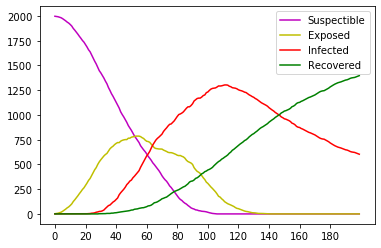

In [8]:
x_axis = range(0, day)
y_axis = range(0, W.population)

plt.xticks(np.arange(0, day, step = day//10))
plt.plot(x_axis, S_list[:day], 'm', label='Suspectible')
plt.plot(x_axis, E_list[:day], 'y', label='Exposed')
plt.plot(x_axis, I_list[:day], 'r', label='Infected')
plt.plot(x_axis, R_list[:day], 'g', label='Recovered')
plt.legend(loc='upper right')
plt.show()

# More Complex Model: Considering Mortality and Quarantine
The model above is not quite realistic. In real world many people died from COVID-19. Also, people showing symptoms will go to hospital and be quarantined to avoid contacts.
Specifically, we add to extra parameter $Q$ which stand for the number of infected population being quarantined in hospital. They also have a higher probability to recover. Then, the ODE formula can be expressed as 
$$\frac{d S}{d t} =-\beta \frac{S I}{N}$$

$$\frac{d E}{d t} =\beta \frac{S I}{N}-\sigma E$$

$$\frac{d I}{d t} =\sigma E-(\gamma_1+q+\mu) I$$

$$\frac{d R}{d t} =\gamma_1 I+\gamma_2Q$$

$$\frac{d Q}{d t} =qI$$

- $q$ is the proportion of population being self-quarantined.
- $\gamma_1$ is	the rate an infected recovers and moves into the resistant phase, 
- $\gamma_2$ is	the rate an quarantined recovers and moves into the resistant phase, 
- $\mu$ is the mortality rate related to disease.

## Conceptual model

Now our conceptual model about cells need to be updated.

Cell: Every cell of $G$ is in one of six possible colors, white, yellow, red, green, blue or black. Each of them stands for a person in the corresponding states:
1. **White Cell, Susceptible (S)**:This person has never gotten the illness before. If this person comes in close contact with a sick person, he/she is at risk of catching the illness. 
2. **Yellow Cell, Exposed (E)**: This person has been infected but is not showing symptoms. This person carries the virus and can infect its neighbor cells. After an incubation period of T days, this person will become Infected.
3. **Red  Cell,  Infected  (I)**: This person has the illness and showing symptoms.
4. **Green Cell, Recovered (R)**: This person had the illness but has fully recovered. He/she cannot become sick again.
5. **Blue Cell, Quarantined (Q)**: This person is quarantined in the hospital and will not infect others.
6. **Black Cell, Dead (D)**: This person died from the illness.

These states are associated with the following integers:

In [9]:
# Health states
SUSCEPTIBLE = 0
EXPOSED = 1
INFECTED = 2
RECOVERED = 3
QUARANTINED = 4
DEAD = 5

#Infection rate and recovery rate
rate_S_E = 0.3 # beta
rate_I_R = 0.01 # gamma_1
rate_H_R = 0.15 # gamma_2
rate_I_D = 0.02 # mu

#Colors
BLACK = (0,0,0)
WHITE = (255,255,255)
RED = (0 ,0,255)
GREEN = (0,255,0)
YELLOW = (0,255,255)
BLUE = (255,153,51)

The evolution rules are also modified accordingly. 

In [10]:
class Cell(object):
    def __init__(self, x, y, world, status = SUSCEPTIBLE, incub_period = 14, rate_S_E = rate_S_E):
        self.x = x
        self.y = y
        self.world = world
        self.status = status
        self.incub_period = incub_period
        self.rate_S_E = rate_S_E

    def get_neighbors(self):
        # this function returns the neighbor coordinates of the cell
        neighbors = []
        for nx, ny in [(self.x + 1, self.y), (self.x - 1, self.y), (self.x, self.y + 1), (self.x, self.y - 1)]:
            if 0 <= nx < self.world.x_count and 0 <= ny < self.world.y_count:
                neighbors.append((nx, ny))
        return neighbors

    def be_exposed(self):
        if self.status == SUSCEPTIBLE:
            fill_grid(self.x, self.y, YELLOW)
            self.status = EXPOSED
            self.world.exposed_cells.append(self)

    def cell_develop(self):
        world = self.world       
        if self.status == EXPOSED:
            self.incub_period -= 1 
            if self.incub_period == 0:
                if world.hospital_count < world.hospital_capacity:
                    self.go_hospital()
                else:
                    self.be_infected()
                self.world.exposed_cells.remove(self)

    def be_infected(self):
        if self.status != INFECTED and self.status != RECOVERED:
            fill_grid(self.x, self.y, RED)
            self.status = INFECTED
            self.world.infected_cells.append(self)

    def be_recovered(self):
        if self.status != RECOVERED and self.status != SUSCEPTIBLE:
            fill_grid(self.x, self.y, GREEN)
            self.status = RECOVERED
            self.world.recovered_count += 1

    def go_hospital(self):
        world = self.world
        if world.hospital_count < world.hospital_capacity:
            fill_grid(self.x, self.y, BLUE)
            self.status = QUARANTINED
            world.hospital_cells.append(self)
            world.hospital_count += 1

    def die(self):
        fill_grid(self.x, self.y, BLACK)
        self.status = DEAD
        self.world.death += 1            

    def expose_neighbors(self):
        neighbors = self.get_neighbors()
        for nx, ny in neighbors:
            neighbor_cell = self.world.cells[nx][ny]
            if neighbor_cell.status == SUSCEPTIBLE:
                if random.random() < self.rate_S_E:
                    neighbor_cell.be_exposed()


#Create the world of cells
class World(object):
    def __init__(self, x_count, y_count, hospital_capacity = 20, rate_S_E = rate_S_E, incub_period = 14):
        self.x_count = x_count
        self.y_count = y_count
        self.population = x_count * y_count
        self.hospital_capacity = hospital_capacity
        self.cells = [[Cell(i, j, self, rate_S_E = rate_S_E, incub_period = incub_period) for j in range(y_count)] for i in range(x_count)]
        self.infected_cells = []
        self.exposed_cells = []    
        self.hospital_cells = []    
        self.exposed_count = 0
        self.infected_count = 0
        self.hospital_count = 0
        self.recovered_count = 0
        self.death = 0
        
    def update(self):
        self.spread()
        self.develop()
        self.recover()
        self.fill_hospital() 
        self.count()  
             

    def spread(self):
        for i in range(len(self.exposed_cells)):
            self.exposed_cells[i].expose_neighbors()
        for i in range(len(self.infected_cells)):
            self.infected_cells[i].expose_neighbors()

    def develop(self):
        for cell in self.exposed_cells:
            cell.cell_develop()
        for cell in self.infected_cells:
            if random.random() < rate_I_D:
                cell.die()
                self.infected_cells.remove(cell)

    def recover(self, rate_I_R = rate_I_R):
        for cell in self.infected_cells:
            if random.random() < rate_I_R:
                cell.be_recovered()
                self.infected_cells.remove(cell)

        for cell in self.hospital_cells:
            if random.random() < rate_H_R:
                cell.be_recovered()
                self.hospital_cells.remove(cell)
                self.hospital_count -= 1


    def fill_hospital(self):
        for cell in self.infected_cells:
            if self.hospital_count == self.hospital_capacity:
                break
            cell.go_hospital()
            self.infected_cells.remove(cell)
                
    def terminate(self):
        return (self.recovered_count + self.hospital_count + self.death) == W.population

    def count(self):
        self.exposed_count = 0
        self.infected_count = 0
        self.exposed_cells = []
        self.infected_cells = []
        for i in range(self.x_count):
            for j in range(self.y_count):
                if self.cells[i][j].status == EXPOSED:
                    self.exposed_count += 1
                    self.exposed_cells.append(self.cells[i][j])
                elif self.cells[i][j].status == INFECTED:
                    self.infected_count += 1
                    self.infected_cells.append(self.cells[i][j])
        self.hospital_count = len(self.hospital_cells)

## Simulation with the modified SEIR-CA model

In [11]:
cv2.namedWindow('grid')

x_count, y_count = 50, 40
grid_size = 20
width, height = x_count * grid_size, y_count * grid_size
#Create a grid for visualization and set all blocks to be white (suspectible)
grid = np.ones((height, width, 3), dtype = np.uint8)
grid[:,:,] = 255 * grid[:,:,]

draw_lines() 
cv2.imshow('grid', grid)
W = World(x_count, y_count)
#Randomly initialize the first infected
rand_x = random.randint(0, x_count)
rand_y = random.randint(0, y_count)
W.cells[rand_x][rand_y].be_exposed()
day = 0
max_iter = 200
S_list = [0] * max_iter
E_list = [0] * max_iter
I_list = [0] * max_iter
R_list = [0] * max_iter
H_list = [0] * max_iter
D_list = [0] * max_iter


while not W.terminate() and day < max_iter:
    cv2.imshow('grid', grid)
    W.update()
    suspectibleNum = W.population - W.recovered_count - W.exposed_count - W.infected_count - W.hospital_count - W.death
    S_list[day], E_list[day], I_list[day], R_list[day], H_list[day], D_list[day] = suspectibleNum, W.exposed_count, W.infected_count, W.recovered_count, W.hospital_count, W.death
    day += 1
    if day in range(50, 60):
        print("Day {}, suspectible: {}, exposed: {}, infected:{}, recovered:{}, hospital: {}, death: {}"\
            .format(day, suspectibleNum, W.exposed_count, W.infected_count, W.recovered_count, W.hospital_count, W.death))
    if cv2.waitKey(27)&0xFF==ord(' '):
        break
    cv2.waitKey(100)    

cv2.imshow('grid', grid)

Day 50, suspectible: 907, exposed: 522, infected:330, recovered:129, hospital: 20, death: 92
Day 51, suspectible: 875, exposed: 521, infected:351, recovered:135, hospital: 20, death: 98
Day 52, suspectible: 840, exposed: 526, infected:367, recovered:142, hospital: 20, death: 105
Day 53, suspectible: 796, exposed: 538, infected:387, recovered:147, hospital: 20, death: 112
Day 54, suspectible: 758, exposed: 546, infected:404, recovered:152, hospital: 20, death: 120
Day 55, suspectible: 718, exposed: 552, infected:424, recovered:160, hospital: 20, death: 126
Day 56, suspectible: 675, exposed: 554, infected:445, recovered:171, hospital: 20, death: 135
Day 57, suspectible: 638, exposed: 558, infected:460, recovered:179, hospital: 20, death: 145
Day 58, suspectible: 608, exposed: 550, infected:485, recovered:187, hospital: 20, death: 150
Day 59, suspectible: 578, exposed: 542, infected:506, recovered:191, hospital: 20, death: 163


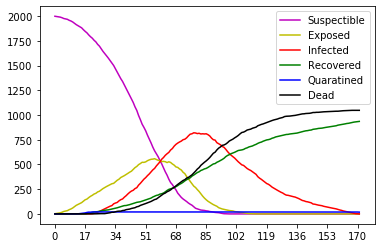

In [12]:
x_axis = range(0, day)
y_axis = range(0, W.population)


plt.xticks(np.arange(0, day, step = day//10))
plt.plot(x_axis, S_list[:day], 'm', label='Suspectible')
plt.plot(x_axis, E_list[:day], 'y', label='Exposed')
plt.plot(x_axis, I_list[:day], 'r', label='Infected')
plt.plot(x_axis, R_list[:day], 'g', label='Recovered')
plt.plot(x_axis, H_list[:day], 'b', label='Quaratined')
plt.plot(x_axis, D_list[:day], 'k', label='Dead')
plt.legend(loc='upper right')
plt.show()

## Sensitivity study with the modified SEIR-CA model
Now, we want to investigate the influence of different parameters on our model. We focus on the number of infected populaiton under different parameters. The simulation process is defined in the function below for parameter changes.

In [13]:
def modified_sim(hospital_rate = 0.002, rate_S_E = 0.1, incub_period = 14):
    x_count, y_count = 70, 60
    population = x_count * y_count
    W = World(x_count, y_count, hospital_capacity = hospital_rate * population, rate_S_E = rate_S_E, incub_period = incub_period)
    #Randomly initialize the first infected
    rand_x = random.randint(0, x_count)
    rand_y = random.randint(0, y_count)
    W.cells[rand_x][rand_y].be_exposed()
    day = 0
    max_iter = 300
    S_list = [0] * max_iter
    E_list = [0] * max_iter
    I_list = [0] * max_iter
    R_list = [0] * max_iter
    H_list = [0] * max_iter
    D_list = [0] * max_iter

    while day < max_iter:
        W.update()
        suspectibleNum = W.population - W.recovered_count - W.exposed_count - W.infected_count - W.hospital_count - W.death
        S_list[day], E_list[day], I_list[day], R_list[day], H_list[day], D_list[day] = suspectibleNum, W.exposed_count, W.infected_count, W.recovered_count, W.hospital_count, W.death
        day += 1
    
    return I_list

## Hospital Availability Sensitivity Study
Three levels of Hospital Availability were investigated:  
- Low: Few infected people are quarantined.  
- Normal: Infected people are quarantined in hosiptal.  
- High: Temporary hospitals are established in response to the disease.   

The result shows that higher hospital availability (higher quarantine level) can effectively reduce the infected number.

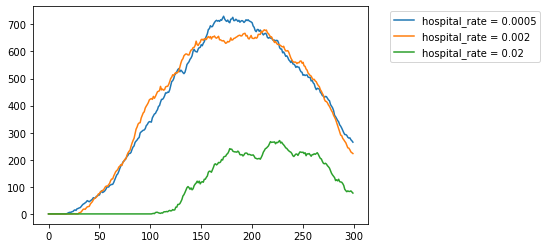

In [14]:
for h_rate in (0.0005, 0.002, 0.02):
    I_list = modified_sim(hospital_rate = h_rate)
    plt.plot(I_list, label = 'hospital_rate = {}'.format(h_rate))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Infection Probability Sensitivity Study
Infection probablity can be different whether people keep social distancing or not.  
The result shows that lower infection probability can flatten the infection curve.

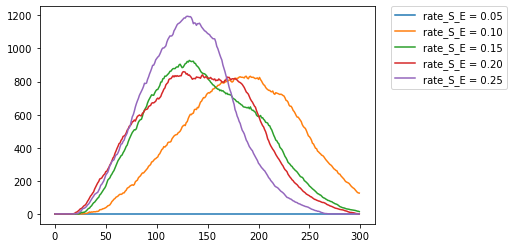

In [15]:
for r_S_E in np.arange(0.05,0.3,0.05):
    I_list = modified_sim(rate_S_E = r_S_E)
    plt.plot(I_list, label = 'rate_S_E = {}'.format('%.2f'%r_S_E))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## Incubation Period Sensitivity Study
We investigate how the average length of the incubation period affacts the spreading of the virus. In the simulation, we assumed all infected person will show symptoms exactly after the Kth days.  
The result doesn't show significant difference.

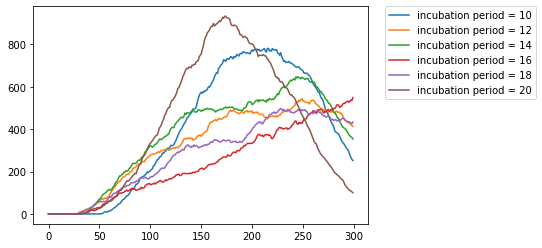

In [16]:
for incub_p in np.arange(10,21,2):
    I_list = modified_sim(incub_period = incub_p)
    plt.plot(I_list, label = 'incubation period = {}'.format(incub_p))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()

## Conclusions
The spreading speed of the virus is:
- highly sensitive to the hospital availability
- highly sensitive to the infection probability
- not quite sensitive to the incubation period
